In [49]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def rmse(y, x):
    return mse(y, x) ** 0.5

# Reading data and initial preprocessing

In [3]:
raw_data = pd.read_csv('AirQualityUCI.csv', header=0, sep=';')

In [4]:
raw_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [5]:
data = raw_data[[col for col in raw_data.columns if 'Unnamed' not in col]].dropna()
data['datetime'] = data['Date'] + ' ' + data['Time'].apply(lambda line: line.replace('.', ':'))
data.drop(['Date', 'Time'], inplace=True, axis=1)
data['datetime'] = pd.to_datetime(data['datetime'])

In [6]:
for col in data.columns:
    if col != 'datetime' and 'float' not in str(data[col].dtype):
        data[col] = data[col].apply(lambda value: value.replace(',', '.'))
        data[col] = data[col].astype('double')

In [7]:
data = data.replace({-200.0: np.nan})

In [8]:
data.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH', 'datetime'],
      dtype='object')

In [9]:
for chem in ['CO', 'NMHC', 'C6H6', 'NO2', 'O3', 'NOx']:
    for col in data.columns:
        if col.startswith(chem):
            data.rename(columns={col: chem}, inplace=True)
        elif chem in col:
            data.rename(columns={col: 'sensor_{}'.format(chem)}, inplace=True)

In [10]:
data.head()

,CO,sensor_CO,NMHC,C6H6,sensor_NMHC,NOx,sensor_NOx,NO2,sensor_NO2,sensor_O3,T,RH,AH,datetime
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-10-03 18:00:00
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-10-03 19:00:00
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-10-03 20:00:00
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-10-03 21:00:00
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-10-03 22:00:00


# Dealing with NaN values

In [11]:
data.isna().sum()

CO             1683
sensor_CO       366
NMHC           8443
C6H6            366
sensor_NMHC     366
NOx            1639
sensor_NOx      366
NO2            1642
sensor_NO2      366
sensor_O3       366
T               366
RH              366
AH              366
datetime          0
dtype: int64

Let's drop the lines that contain only NaN values

In [12]:
from operator import and_
from functools import reduce


data = data[~reduce(and_, [data[col].isna() for col in data.columns if col != 'datetime'])]

Dropping the NMHC column since almost all of its values are NaN

In [13]:
data = data.drop('NMHC', axis=1)

Also for some reason the number of NaNs in all of the sensor columns are equal. Let's check if this means that all those columns have NaNs in same lines, and if it is so let's drop those lines, since they have too few valuable columns.

In [14]:
data = data[~reduce(and_, [data[col].isna() for col in [sensor for sensor in data.columns if sensor.startswith('sensor')]])]

In [15]:
data.isna().sum()

CO             1647
sensor_CO         0
C6H6              0
sensor_NMHC       0
NOx            1595
sensor_NOx        0
NO2            1598
sensor_NO2        0
sensor_O3         0
T                 0
RH                0
AH                0
datetime          0
dtype: int64

Now we have NaN values only in 3 chemical columns. Actually, we should expect a correlation between the sensor data and the actual amount of corresponding chemicals, so lets investigate into this:

SpearmanrResult(correlation=0.8794221473544893, pvalue=0.0)

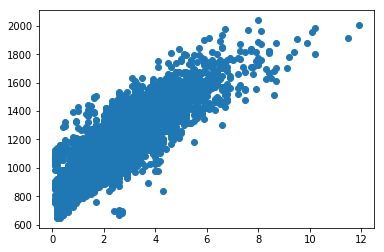

In [16]:
plt.scatter(data['CO'], data['sensor_CO'])

nanless_data = data.dropna(subset=['CO'])
stats.spearmanr(nanless_data['CO'], nanless_data['sensor_CO'])

We definetely have a strong linear dependency between theese columns. This means that we should drop one of them, so let's get rid of CO since it hase a lot of NaN values.

In [17]:
#data = data.drop('CO', axis=1)

In case of NOx and its sensor, it looks like those columns have an inverse dependency.

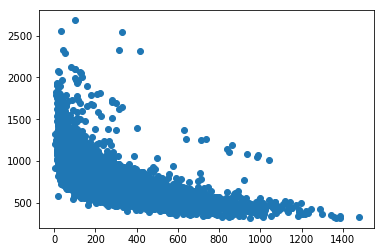

In [18]:
plt.scatter(data['NOx'], data['sensor_NOx'])

In [19]:
nanless_data = data.fillna({
    'NO2': np.nanmean(data['NO2']),
    'NOx': np.nanmean(data['NOx']),
    'CO': np.nanmean(data['CO'])
}, inplace=True)

# Features aggregation:

In [119]:
featured_data = data.copy()
featured_data['hour'] = featured_data['datetime'].dt.hour
featured_data['week_day'] = (featured_data['datetime'].view('int64') - 4) % 7

for col in featured_data.columns:
    if col not in ['datetime', 'week_day', 'hour']:
        featured_data[col + '_squared'] = featured_data[col] ** 2

for col in featured_data.columns:
    if col not in ['datetime', 'week_day', 'hour'] and not col.endswith('squared'):
        featured_data[col + '_cubed'] = featured_data[col] ** 3
        
feature_fields = [col for col in featured_data.columns if col not in ['C6H6', 'datetime']]

In [106]:
featured_data.columns

Index(['CO', 'sensor_CO', 'C6H6', 'sensor_NMHC', 'NOx', 'sensor_NOx', 'NO2',
       'sensor_NO2', 'sensor_O3', 'T', 'RH', 'AH', 'datetime', 'hour',
       'week_day', 'CO_squared', 'sensor_CO_squared', 'C6H6_squared',
       'sensor_NMHC_squared', 'NOx_squared', 'sensor_NOx_squared',
       'NO2_squared', 'sensor_NO2_squared', 'sensor_O3_squared', 'T_squared',
       'RH_squared', 'AH_squared', 'CO_cubed', 'sensor_CO_cubed', 'C6H6_cubed',
       'sensor_NMHC_cubed', 'NOx_cubed', 'sensor_NOx_cubed', 'NO2_cubed',
       'sensor_NO2_cubed', 'sensor_O3_cubed', 'T_cubed', 'RH_cubed',
       'AH_cubed'],
      dtype='object')

# Generating train/test splits for cross-validation

In [133]:
np.random.seed(1)

featured_data.sort_values('datetime', inplace=True)

tscv = TimeSeriesSplit(n_splits=10)

folds = list(tscv.split(featured_data))

# Least squares approximation

In [134]:
for train_ind, test_ind in folds:
    X_train = featured_data.iloc[train_ind][feature_fields]
    X_test = featured_data.iloc[test_ind][feature_fields]
    y_train = featured_data.iloc[train_ind]['C6H6']
    y_test = featured_data.iloc[test_ind]['C6H6']
    
    alpha = np.dot(np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), X_train.T), y_train)
    scores = np.dot(X_test, alpha)
    scores = [score if score > 0 else 0 for score in scores]
    print(rmse(y_test, scores))

0.034010839462671076
0.028875859631759527
0.024763398324166797
0.0250592473433718
0.02412821910380326
0.0302223832706218
0.06407021570071326
0.03962223729331519
0.03389224835608173
0.027553993164619806


# SGD Regression

In [135]:
for train_ind, test_ind in folds:
    X_train = featured_data.iloc[train_ind][feature_fields]
    X_test = featured_data.iloc[test_ind][feature_fields]
    y_train = featured_data.iloc[train_ind]['C6H6']
    y_test = featured_data.iloc[test_ind]['C6H6']

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = SGDRegressor(max_iter=200, tol=0.000005, penalty='l1', alpha=1E-7)
    model = model.fit(X_train, y_train)
    scores = model.predict(X_test)
    scores = [score if score > 0 else 0 for score in scores]
    print(rmse(scores, y_test))

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:1229: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to flo

0.17629665414146636
0.09691453848367206


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.0807417089202139


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.0756210522019942


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.08817948709221414


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.1491185448985569


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.18654519548793935


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.13744902748101687


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.12127500935889017


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.08714801150475399


# LGBM just for fun

In [136]:
for train_ind, test_ind in folds:
    X_train = featured_data.iloc[train_ind][feature_fields]
    X_test = featured_data.iloc[test_ind][feature_fields]
    y_train = featured_data.iloc[train_ind]['C6H6']
    y_test = featured_data.iloc[test_ind]['C6H6']

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = LGBMRegressor(n_estimators=1400, learning_rate=0.01, num_leaves=10, objective='rmse', random_state=1, max_depth=10)

    model.fit(X_train, y_train)

    scores = model.predict(X_test)
    scores = [score if score > 0 else 0 for score in scores]

    print(rmse(y_test, scores))

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.4541884024975195


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.19010001761783085


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.07374500491379953


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.06067956647094405


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.13821257383632482


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.3464376541591429


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.9467042943106276


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.21097049782026414


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.06868134388559041


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0.02994007600071069
